## 1D Steady State Heat Equation (1D Poission Equation)
$$
\begin{gather}
f(x) = 1  \\
\kappa(x) = 1\\  
-\frac{\partial}{\partial x}(\kappa(x) \frac{\partial u}{\partial x}) = f(x) \implies -u''(x) = f(x)\\  
\end{gather}
$$


In [7]:
using Flux, Plots, ForwardDiff, LinearAlgebra, CUDA

Initialization of varibles and vectors

In [8]:
f(x) = 1
L = 1
u_sol(x) = (x-x^2)*0.5
u_0 = [0 for i in 1:1] |> gpu
u_1 = [0 for i in 1:1] |> gpu

measurements = [rand(Float64) for i in 1:30] |> gpu #Shouldn't be used as of right now
collocations = [rand(Float64) for i in 1:100] |> gpu;

Neural Network with 10 hidden layers and 40 neurons per layer

In [9]:
u = Chain( x->[x],
    Dense(1 => 40,tanh),
    Dense(40 => 40,tanh),Dense(40 => 40,tanh),Dense(40 => 40,tanh),Dense(40 => 40,tanh),
    Dense(40 => 40,tanh),Dense(40 => 40,tanh),Dense(40 => 40,tanh),Dense(40 => 40,tanh),
    Dense(40 => 1),
    first) |> gpu;

Mean Square Error Loss Function for data and differential equation

In [10]:
∂2u∂x2(x) = ForwardDiff.derivative(x->ForwardDiff.derivative(u,x),x)
loss_ode() = sum(abs2, (-∂2u∂x2(x) - f(x) for x in collocations))/length(collocations)
loss_data() = sum(abs2, (u(x) - u_sol(x) for x in measurements))/length(measurements) + sum(abs2, (u(0)-u_0[i] for i in eachindex(u_0)))/length(u_0) + sum(abs2, (u(L)-u_1[i] for i in eachindex(u_1)))/length(u_1)         #What I'm trying to avoid
composed_loss() =  loss_ode() #+ 0.38*loss_data()

composed_loss (generic function with 1 method)

Training of Neural Network with the Adam optimizer for 5000 iterations

In [11]:
opt = Flux.Adam()
data = Iterators.repeated((), 5000)
iter = 0
cb = function () #callback function to observe training
    global iter += 1
    if iter % 500 == 0
        display(composed_loss())
    end
end

Flux.train!(composed_loss, Flux.params(u), data, opt)

Plotting solution and calculating error in the 2-norm

"The error is 0.48496136916894106"

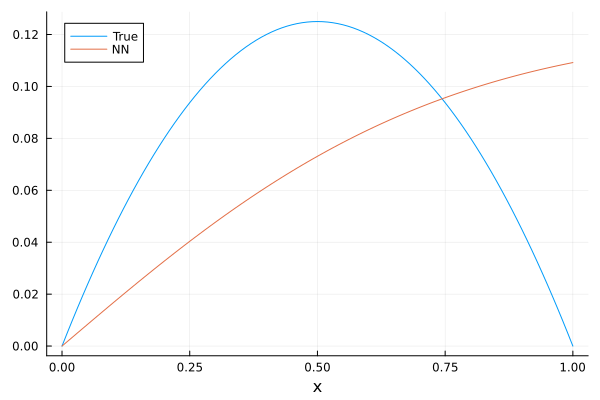

In [12]:
plot_t = 0:0.01:L

learned_plot = u.(plot_t) |> gpu
real_plot = u_sol.(plot_t) |> gpu

error = norm(learned_plot - real_plot)

display("The error is $error")

plot(plot_t,real_plot,xlabel="x",label="True")
plot!(plot_t,learned_plot,label="NN")
#scatter!(measurements,u_sol.(measurements),label="Measurements")